In [11]:
import LC_model
from LC_GenMock import *
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import scipy.stats as st
import emcee
%matplotlib inline

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


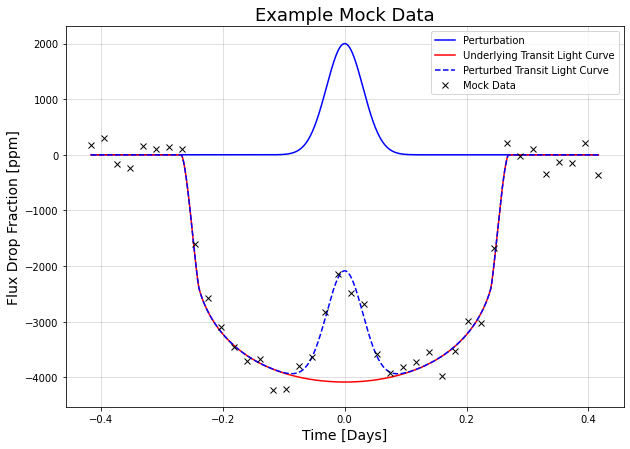

In [12]:
spot_stength = 2000 #ppm
spot_width = 0.03 #days
transit_window = 10 #hours
spot_location = 0 #days
theta_0 = [140.5,0.0576,1.571, 224.22]
ld_coef = [0.47,0.19]
results = generate_mock_data(theta_0,ld_coef,transit_window,
                             spot_location,spot_stength,spot_width)
x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
fig = plot_mock_data( *results)

In [13]:
# need this for mcmc input
time = x_mock
flux = y_mock*1e-6+1

# this is for MCMC
def lnprior(theta):
    ap_rs,rp_rs,inc,period,gamma1,gamma2 = theta
    if (10<ap_rs<400 and 0<rp_rs<0.3 and np.pi/2<inc<np.pi/2+0.01 and
         222.5<period<225.72 and gamma1+gamma2<1 and gamma1>0 and gamma2>0):
        return 0.0
    return -np.inf

def lnlike(theta,time,flux,sig):
    """
    Log likelyhood function, least squre model minimization.
    Assuming quadratic limb darkening law.
    """
    fit = LC_model.transit_fit(theta[:-2],theta[-2:],method="quad_ld")
    model = fit.transit_model(time)
    return -np.sum((model-flux)**2/sig**2)  #+ np.log(sig))

def lnprob(theta,args):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta,*args)

def MCMC_run(time,flux,theta,iteration=1000):
    divp = 0.3 #spread on period
    p_min,p_max = theta[3]-divp*5,theta[3]+divp*5
    sig1 = np.zeros(len(time))+1e-6
    ndim, nwalkers = len(theta), 60
    args = [time,flux,sig1]
    p0 = np.random.normal(theta[0],10,nwalkers) #a_p/rs (z0)
    p1 = np.random.normal(theta[1],0.01,nwalkers) #rp/rs (p)
    p2 = np.random.normal(theta[2],0.002,nwalkers) #inc [rad]
    p3 = np.random.normal(theta[3],divp,nwalkers) #period [days]
    p4 = np.random.normal(theta[4],0.05,nwalkers) #gam_1 >0
    p5 = np.random.normal(theta[5],0.05,nwalkers) #gam_2 >0

    pos = np.array([p0,p1,p2,p3,p4,p5]).T
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[args],threads=8)
    pos = sampler.run_mcmc(pos, iteration);
    return sampler.get_chain()

In [14]:
theta = 140.5,0.0576,np.pi/2+0.005, 224.22,0.47,0.19
sampler = MCMC_run(time,flux,theta,iteration=1000)

In [20]:
samplers = np.empty([2,1000,60,6])
samplers[0,:,:,:] = sampler
for i in range(samplers.shape[0]):
    if(i == 0):
        results = generate_mock_data(theta_0,ld_coef,transit_window,
                                 spot_location,spot_stength,spot_width)
        x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
        time = x_mock
        flux = y_mock*1e-6+1
    else:
        results = generate_mock_data(theta_0,ld_coef,transit_window,
                                 spot_location,0,spot_width)
        x_mock, y_mock, x_true, y_true, anomaly, y_anomaly = results
        time = np.append(time,x_mock)
        flux = np.append(flux,y_mock*1e-6+1)
    samplers[i,:,:,:] = MCMC_run(time,flux,theta,iteration=1000)
    
    print(time,flux)

[-0.41631944 -0.39548611 -0.37395833 -0.35243056 -0.33159722 -0.31006944
 -0.28854167 -0.26701389 -0.24618056 -0.22465278 -0.203125   -0.18159722
 -0.16076389 -0.13923611 -0.11770833 -0.09618056 -0.07534722 -0.05381944
 -0.03229167 -0.01076389  0.01006944  0.03159722  0.053125    0.07465278
  0.09548611  0.11701389  0.13854167  0.16006944  0.18090278  0.20243056
  0.22395833  0.24548611  0.26631944  0.28784722  0.309375    0.33090278
  0.35173611  0.37326389  0.39479167  0.41631944] [0.99975301 1.00026662 0.99995172 1.00012465 1.00004775 1.00000867
 1.0000665  1.00019804 0.99833341 0.99731553 0.99699515 0.99711977
 0.99622334 0.99611855 0.99619133 0.99603522 0.99631485 0.99658191
 0.99710205 0.9975781  0.99824831 0.99754223 0.99659915 0.99598253
 0.99622645 0.99616037 0.99609576 0.99608363 0.99635766 0.99679291
 0.99710086 0.99821675 0.99996909 1.00018191 1.00006969 0.9999574
 1.00018326 1.00016618 0.9998954  1.00000154]
emcee: Exception while calling your likelihood function:
  params

Traceback (most recent call last):
  File "/home/jacob/.local/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-13-f6b09c8f7697>", line 24, in lnprob
    return lp + lnlike(theta,*args)
  File "<ipython-input-13-f6b09c8f7697>", line 18, in lnlike
    model = fit.transit_model(time)
  File "/home/jacob/JAS1101/LC.py/LC_model.py", line 97, in transit_model
    Flux[i] = self.model(p,z)
  File "/home/jacob/JAS1101/LC.py/LC_model.py", line 103, in flux_quadld
    lambda_d,eta_d = self.cases(p,z)
  File "/home/jacob/JAS1101/LC.py/LC_model.py", line 118, in cases
    return self.lambda_i(1,p,z),self.eta_1(p,z)
  File "/home/jacob/JAS1101/LC.py/LC_model.py", line 197, in lambda_i
    - 3*q/a*self.ellip_thi((a-1)/a,k) )
  File "/home/jacob/JAS1101/LC.py/LC_model.py", line 263, in ellip_thi
    return mp.ellippi(n,np.pi/2,k**2)
  File "/home/jacob/.local/lib/python3.6/site-packages/mpmath/ctx_mp_python.py

KeyboardInterrupt: 